<a id="a1"></a>
# Import the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import requests
from io import StringIO

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
#function to display dataframes side by side    
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)

ModuleNotFoundError: No module named 'pandas_profiling'

In [2]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

In [3]:
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)            

<a id="a2"></a>
# Read the data as a data frame

In [4]:
# orig_url='https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing'
# file_id = orig_url.split('/')[-2]
# file_id

In [5]:
# dwn_url='http://drive.google.com/uc?export=download&confirm=pAkV&id=' + file_id
# url = requests.get(dwn_url)
# url.text

In [6]:
electronics = pd.read_csv('../input/ratings_Electronics.csv', names=['userId', 'productId', 'Rating','timestamp'], header=None)

In [7]:
electronics.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


<a id="a3"></a>
# Attributes and Information

1. **userId** : Every user identified with a unique id<br>
2. **productId** : Every product identified with a unique id<br>
3. **Rating** : Rating of the corresponding product by the corresponding user<br>
4. **timestamp** : Time of the rating

<a id="a4"></a>
# Perform basic EDA

<a id="a4a"></a>
## a. Drop 'timestamp' attribute

In [8]:
electronics.drop('timestamp', axis=1, inplace=True)

<a id="a4b"></a>
## b. Create subset of the original dataset

**Filtering the users who has given 50 or more number of ratings**

In [9]:
electronics_groupby_users_Ratings = electronics.groupby('userId')['Rating']
electronics_groupby_users_Ratings = pd.DataFrame(electronics_groupby_users_Ratings.count())

In [10]:
user_list_min50_ratings = electronics_groupby_users_Ratings[electronics_groupby_users_Ratings['Rating'] >= 50].index
electronics =  electronics[electronics['userId'].isin(user_list_min50_ratings)]

<a id="a4c"></a>
## c. Shape of the data

In [11]:
print('The total number of rows :', electronics.shape[0])
print('The total number of columns :', electronics.shape[1])

The total number of rows : 125871
The total number of columns : 3


<a id="a4d"></a>
## d. Data type of each attribute

In [12]:
electronics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
userId       125871 non-null object
productId    125871 non-null object
Rating       125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


<a id="a4e"></a>
## e. Checking the presence of missing values

In [13]:
display(electronics.isna().sum().sort_values())
print('===================')
printmd('**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data', color="blue")

userId       0
productId    0
Rating       0
dtype: int64

<span style='color:blue'>**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data</span>

<a id="a4f"></a>
## f. 5 point summary of numerical attributes

In [14]:
display(electronics[['Rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Rating,125871.0,4.261339,1.062144,1.0,4.0,5.0,5.0,5.0


### Observations

**Rating** : This is can be considered as categorical attribute with values of (1,2,3,4,5). The mean rating is 4.26 which means most of the users have given very good ratings for the products i.e. many records with ratings above 4. This can be seen from the median (Q2), 75% (Q3) and max values as 5. Even 25% (Q1) value is 4.0. 

<a id="a4g"></a>
## g. Unique Users and Products Count

In [15]:
print('Total unique users in the dataset', electronics['userId'].nunique())
print('Total unique products in the dataset', electronics['productId'].nunique())

Total unique users in the dataset 1540
Total unique products in the dataset 48190


<a id="a5"></a>
# Data Analysis and Visualization

<a id="a5a"></a>
## a. Rating Distribution

In [16]:
pal = sns.color_palette(palette='Set1', n_colors=16)

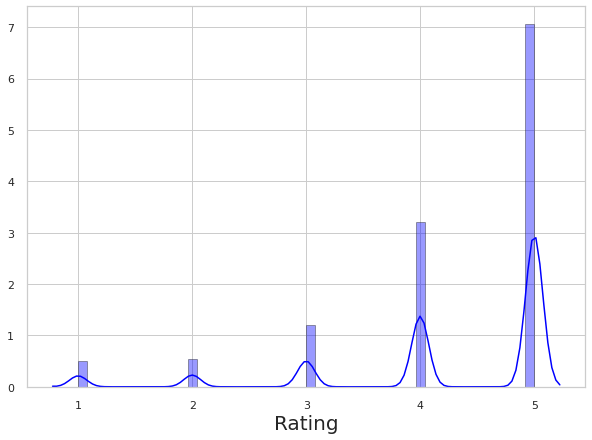

In [17]:
distplot(1, 1, 10, 7, data=electronics, features=['Rating'], colors=['blue'])

### Observations

1. Many users have rated 5 as it is shown with the huge spike
2. This is followed by rating 4 which also has high number
3. Ratings 1, 2, 3 are comparatively less.

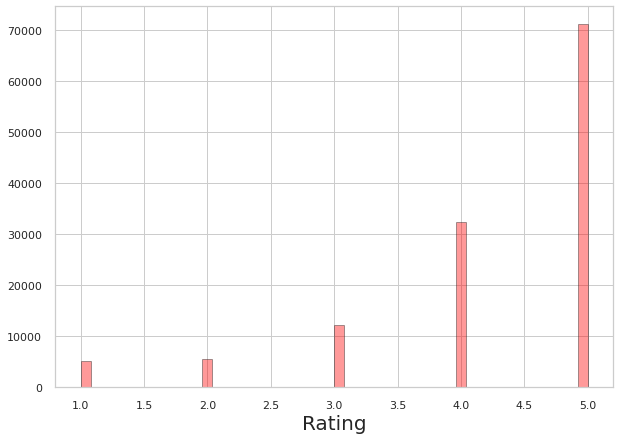

In [18]:
distplot(1, 1, 10, 7, data=electronics, features=['Rating'], colors=['red'], kde=False)

### Observations

1. Many users have rated 5 as it is shown with the huge spike with a value of more than 70k records.
2. This is followed by rating 4 which also has high number with a value of mroe than 30k records.
3. More than 10k users have rated 3.
4. Rating 1 and 2 have been rated below 10k records.

<a id="a5b"></a>
## b. Top Rating Count Distribution grouped by Products

In [19]:
electronics_groupby_products_Ratings = electronics.groupby('productId')['Rating']

In [20]:
electronics_groupby_products_Ratings.count().clip(upper=30).unique()

array([ 1,  2,  4,  6,  5,  8,  3,  7, 12,  9, 17, 16, 10, 13, 21, 19, 11,
       18, 14, 30, 15, 28, 23, 29, 24, 22, 25, 20, 26, 27])

In [21]:
ratings_products = pd.DataFrame(electronics_groupby_products_Ratings.count().clip(upper=30))
ratings_products.rename(columns={"Rating": "Rating_Count"}, inplace=True)

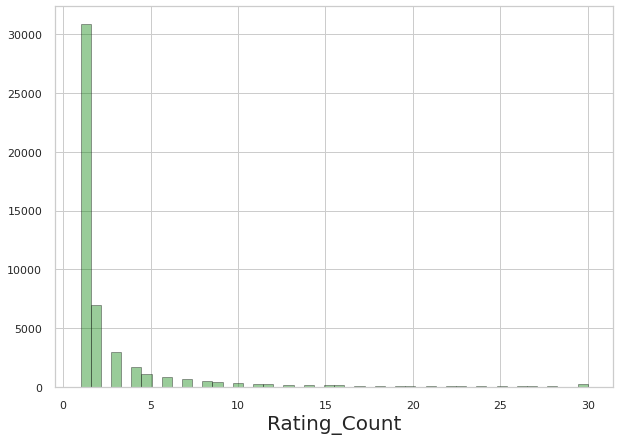

In [22]:
distplot(1, 1, 10, 7, data=ratings_products, features=['Rating_Count'], colors=['green'], kde=False)

### Observations

This is a ratings count distribution grouped by all the Products. For the plot perspective, I have clipped the upper limit to 30 which means any value above 30 will be set to it. 

As it can been seen from the plot, there are many products which were rated only once i.e. only one user have rated. And then the count decreases.

<a id="a5c"></a>
## c. Top Rating Count Distribution grouped by Users

In [23]:
electronics_groupby_users_Ratings = electronics.groupby('userId')['Rating']

In [24]:
electronics_groupby_users_Ratings.count().clip(lower=50).unique()

array([116, 132,  68,  71,  65,  57,  96,  80, 107, 123,  77, 130,  52,
        89, 112,  67,  86,  66,  75, 205,  58,  50, 216,  92,  54,  64,
        51, 252,  72,  81,  74,  53,  62,  70, 104, 102,  60,  63, 157,
        99,  56,  55,  61, 261, 151,  94,  78, 119,  83,  73, 144, 177,
       149, 106,  82,  69, 108, 196,  76, 221, 197, 200, 155, 208, 207,
       181, 160, 213,  59, 103,  85,  98, 145, 218,  84, 101,  91, 100,
        88, 114,  79,  93, 131, 142, 380,  90,  95, 126, 110, 105,  97,
       167, 227, 128, 127, 247, 129, 220, 121,  87, 202, 109, 156, 111,
       162, 240, 125, 137, 150, 292, 270, 115, 226, 296, 311, 176, 170,
       122, 117, 159, 277, 238, 120, 253, 138, 171, 136, 314, 282, 236,
       257, 204, 146, 124, 174, 279, 118, 199, 209, 498, 266, 143, 169,
       134, 173, 147, 182, 163, 180, 153, 225, 520, 406, 431, 193, 139,
       501, 239, 244, 192, 141, 198, 212, 308, 168, 189])

In [25]:
rating_users = pd.DataFrame(electronics_groupby_users_Ratings.count().clip(lower=50, upper=300))
rating_users.rename(columns={"Rating": "Rating_Count"}, inplace=True)

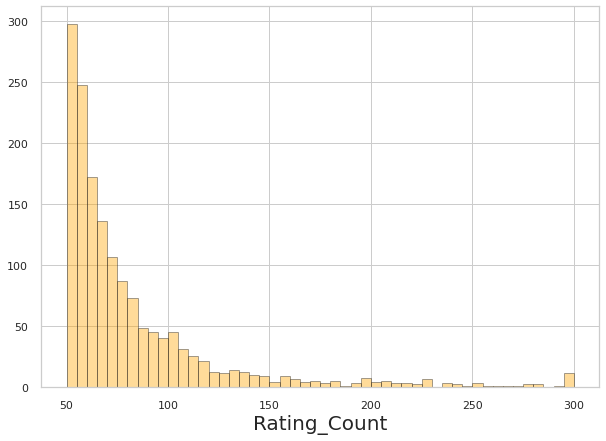

In [26]:
distplot(1, 1, 10, 7, data=rating_users, features=['Rating_Count'], colors=['orange'], kde=False, bins=50)

### Observations

This is a ratings count distribution grouped by all the Users. For the plot perspective, I have clipped the count limit between 50 to 300 which means any value below 50 or above 300 will be set to the respective values. 

As it can been seen from the plot, there are many users which have rated 50 times or below. Ratings count by users gradually decreases which means few users have rated many products. 

<a id="a5d"></a>
## d. Mean Rating Distribution grouped by Products

In [27]:
ratings = pd.DataFrame(electronics.groupby('productId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)

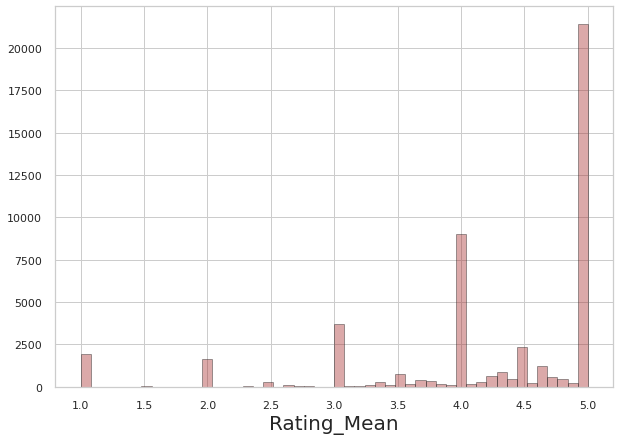

In [28]:
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

### Observations

This is a mean rating distribution grouped by all the Products.

As it can been seen from the plot, there are many products which were given a Rating of 4 or 5. Hence the plot shows lot of bins between 4 and 5. 

<a id="a5e"></a>
## e. Mean Rating - Rating Count Distribution grouped by Products

In [29]:
ratings['Rating_Count'] = electronics.groupby('productId')['Rating'].count()

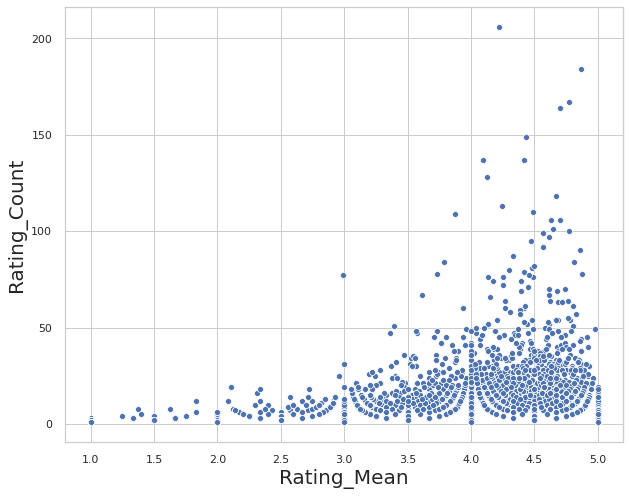

In [30]:
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

### Observations

This is a joint plot between Mean rating distribution and Rating Count grouped by all the Products. As shown in the plot, data is clustered between mean rating of 3.5 to 5. 

<a id="a5f"></a>
## f. Mean Rating Distribution grouped by Users

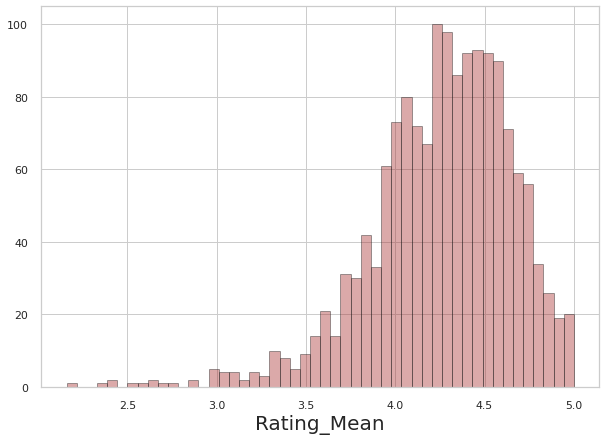

In [31]:
ratings = pd.DataFrame(electronics.groupby('userId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

### Observations

This is a mean rating distribution grouped by all the Users. This looks like slightly left skewed normal distribution.

Data is uniformly distribution from rating 3 to 5 with many around 4 to 4.5. Many users have an average rating of around 4.5. 

<a id="a5g"></a>
## g. Mean Rating - Rating Count Distribution grouped by Users

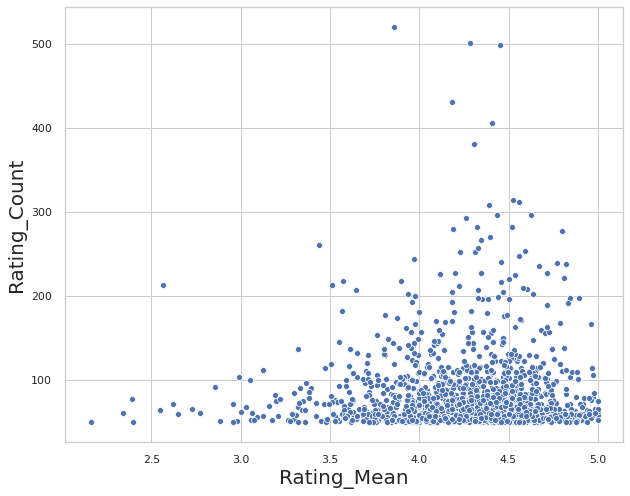

In [32]:
ratings['Rating_Count'] = electronics.groupby('userId')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

### Observations

This is a joint plot between Mean rating distribution and Rating Count grouped by all the Users. As shown in the plot, data is clustered between 3.5 to 5. There are many data points when the Rating count is less than 100 and the mean rating for the users is between 3.5 and 5

<a id="a6"></a>
# Split the data into training and test set in the ratio of 70:30 respectively

In [33]:
train_data, test_data = train_test_split(electronics, test_size =.30, random_state=10)
printmd('**Training and Testing Set Distribution**', color='brown')

print(f'Training set has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Testing set has {test_data.shape[0]} rows and {test_data.shape[1]} columns')


<span style='color:brown'>**Training and Testing Set Distribution**</span>

Training set has 88109 rows and 3 columns
Testing set has 37762 rows and 3 columns


<a id="a7"></a>
# Recommender Systems

A recommender system is a simple algorithm whose aim is to provide the most relevant information to a user by discovering patterns in a dataset. The algorithm rates the items and shows the user the items that they would rate highly.

<a id="a7a"></a>
## a. Popularity Based Recommender Model

Popularity based recommendation system uses the items that are in trend right now. It ranks products based on its popularity i.e. the rating count. If a product is highly rated then it is most likely to be ranked higher and hence will be recommended. As it is based on the products popularity, this can not be personalized and hence same set of products will be recommended for all the users.

In [34]:
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def fit(self):
        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(20)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, n=5):    
        user_recommendations = self.popularity_recommendations
        
        #Filter products that are not rated by the user
        products_already_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]        
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(products_already_rated_by_user)]
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)     
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        f, axes = plt.subplots(1, 2, figsize=(20, 8))
        cplot1 = sns.barplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[0])
        cplot1.set_xlabel('Rank',fontsize=20)
        cplot1.set_ylabel('score',fontsize=20)            
        cplot2 = sns.pointplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[1])
        cplot2.set_xlabel('Rank',fontsize=20)
        cplot2.set_ylabel('score',fontsize=20)
        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['Rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['Rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse
        
        

<a id="a7a1"></a>
### Initialize

In [35]:
pr = popularity_based_recommender_model(train_data=train_data, test_data=test_data, user_id='userId', item_id='productId')

<a id="a7a2"></a>
### Fit

In [36]:
pr.fit()

<a id="a7a3"></a>
### Recommend

**Trying with three different Users**

,user_id,productId,score,Rank
30874,ANTN61S4L7WG9,B0088CJT4U,142,1.0
19570,ANTN61S4L7WG9,B003ES5ZUU,134,2.0
30273,ANTN61S4L7WG9,B007WTAJTO,126,3.0
30557,ANTN61S4L7WG9,B00829THK0,103,6.0
17292,ANTN61S4L7WG9,B002R5AM7C,97,8.0


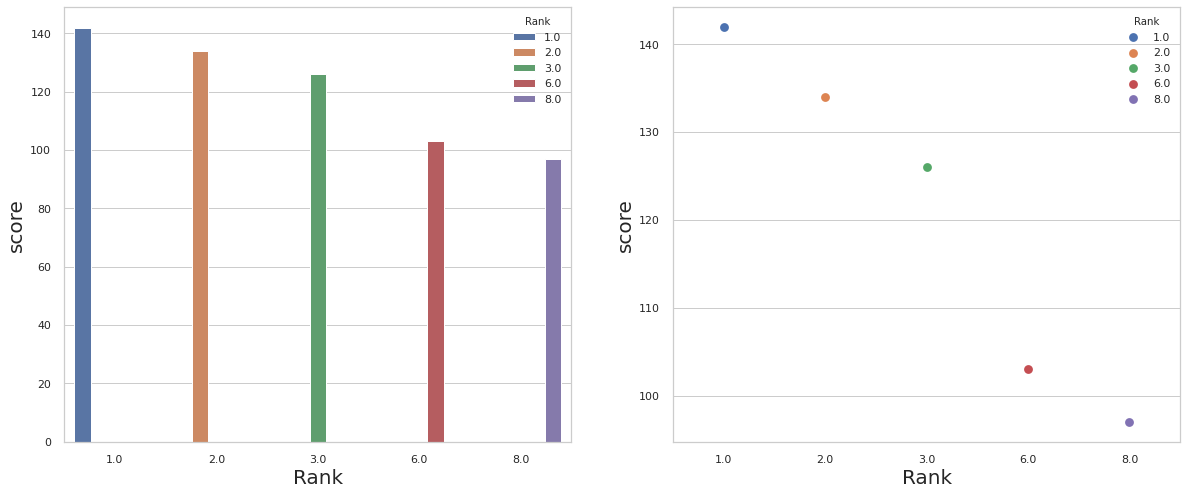

In [37]:
result_pop_user1 = pr.recommend('ANTN61S4L7WG9')
result_pop_user1

,user_id,productId,score,Rank
30874,AYNAH993VDECT,B0088CJT4U,142,1.0
19570,AYNAH993VDECT,B003ES5ZUU,134,2.0
30273,AYNAH993VDECT,B007WTAJTO,126,3.0
8700,AYNAH993VDECT,B000N99BBC,117,4.0
30561,AYNAH993VDECT,B00829TIEK,104,5.0


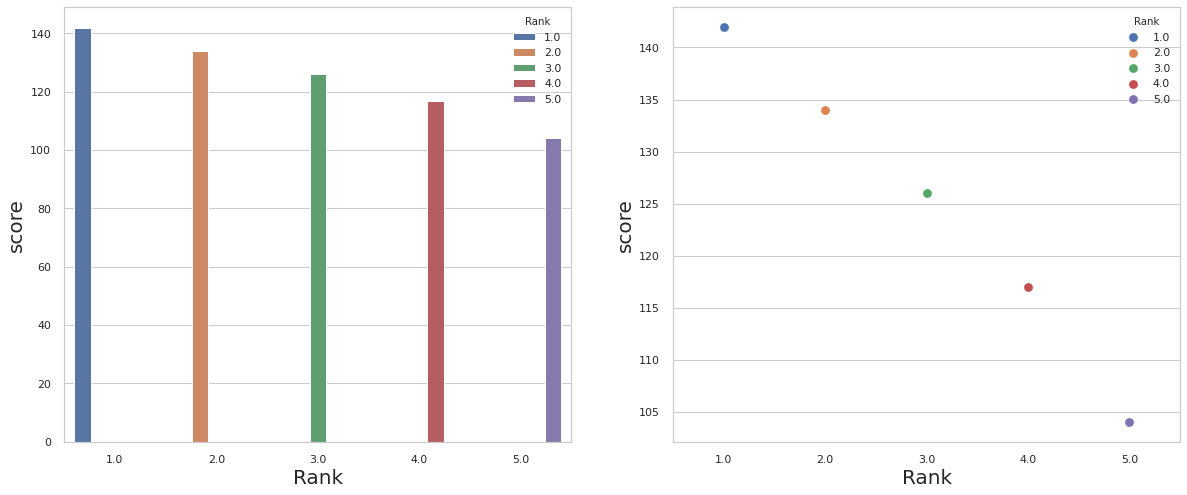

In [38]:
result_pop_user2 = pr.recommend('AYNAH993VDECT')
result_pop_user2

,user_id,productId,score,Rank
30874,A18YMFFJW974QS,B0088CJT4U,142,1.0
19570,A18YMFFJW974QS,B003ES5ZUU,134,2.0
30273,A18YMFFJW974QS,B007WTAJTO,126,3.0
8700,A18YMFFJW974QS,B000N99BBC,117,4.0
30561,A18YMFFJW974QS,B00829TIEK,104,5.0


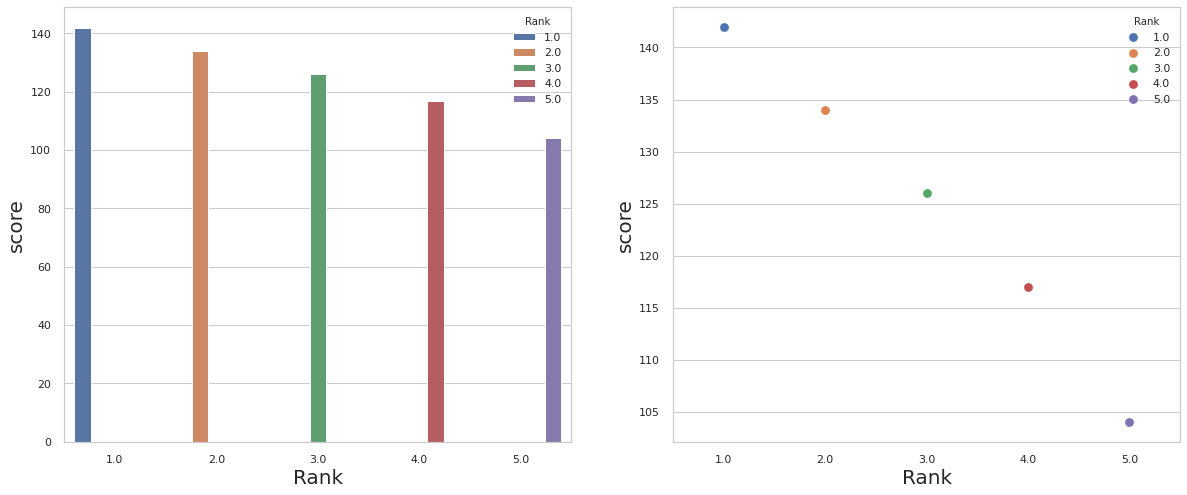

In [39]:
result_pop_user3 = pr.recommend('A18YMFFJW974QS')
result_pop_user3

In [40]:
display_side_by_side([result_pop_user1, result_pop_user2, result_pop_user3])

,user_id,productId,score,Rank
30874,ANTN61S4L7WG9,B0088CJT4U,142,1.0
19570,ANTN61S4L7WG9,B003ES5ZUU,134,2.0
30273,ANTN61S4L7WG9,B007WTAJTO,126,3.0
30557,ANTN61S4L7WG9,B00829THK0,103,6.0
17292,ANTN61S4L7WG9,B002R5AM7C,97,8.0
,user_id,productId,score,Rank
30874,AYNAH993VDECT,B0088CJT4U,142,1.0
19570,AYNAH993VDECT,B003ES5ZUU,134,2.0
30273,AYNAH993VDECT,B007WTAJTO,126,3.0
8700,AYNAH993VDECT,B000N99BBC,117,4.0


In [41]:
pr.predict_evaluate()

2.5098939142231482

<a id="a7a4"></a>
### Observations

Since this is a popularity based recommender model, we are getting same result for all three users i.e. **the model is recommending same products for all the users**.

<a id="a7b"></a>
## b. Collaborative Filtering Recommender Model using SURPRISE Library

Collaborative filtering is a method of making predictions about the interests of user by analysing the taste of users which are similar to the said user. The idea of filtering patterns by collaborating multiple viewpoints is why it is called collaborative filtering.

<a id="a7b1"></a>
### Load Surprise Data from DataFrame

In [42]:
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans
reader = Reader()
surprise_data = Dataset.load_from_df(electronics, reader)

<a id="a7b2"></a>
### Split the data into training and test set in the ratio of 70:30 respectively

In [43]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

In [44]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [45]:
class collab_filtering_based_recommender_model():
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        printmd('**Fitting the train data...**', color='brown')
        self.model.fit(self.trainset)       

        printmd('**Predicting the test data...**', color='brown')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='brown')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['userId', 'productId', 'Rating'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['productId', 'Rating'])
            subdf['userId'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]        
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
        return rmse
        
    def cross_validate(self):
        printmd('**Cross Validating the data...**', color='brown')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='brown')
        return cv_result

    def recommend(self, user_id, n=5):
        printmd('**Recommending top ' + str(n)+ ' products for userid : ' + user_id + ' ...**', color='brown')
        
        #df = pd.DataFrame(self.top_n[user_id], columns=['productId', 'Rating'])
        #df['UserId'] = user_id
        #cols = df.columns.tolist()
        #cols = cols[-1:] + cols[:-1]
        #df = df[cols].head(n)
        df = self.recommenddf[self.recommenddf['userId'] == user_id].head(n)
        display(df)
        return df
        

In [46]:
from surprise.model_selection import RandomizedSearchCV

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

<a id="a7b3"></a>
### KNN With Means - Memory Based Collaborative Filtering

**User-User Collaborative Filtering**

To find the rating R that a user U would give to an item I, the approach includes:

1. Finding users similar to U who have rated the item I<br>
2. Calculating the rating R based the ratings of users found in the previous step

Here we are using KNN with means to remove the bias by taking into account the mean ratings of each user.

<a id="a7b3a"></a>
#### Find optimal model using RandomizedSearchCV

In [47]:
sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 1.0355723444791871}
{'rmse': {'k': 31, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f8c0e413eb8>}


<a id="a7b3b"></a>
#### Initialize

In [48]:
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender_model(knnwithmeans, trainset, testset, surprise_data)

<a id="a7b3c"></a>
#### Fit and Predict

In [49]:
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.


<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 1.0417


<span style='color:brown'>**RMSE for the predicted result is 1.042**</span>

<a id="a7b3d"></a>
#### Cross Validate

In [50]:
knnwithmeans_cv_rmse = col_fil_knnwithmeans.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 1.037**</span>

<a id="a7b3e"></a>
#### Recommend

In [51]:
result_knn_user1 = col_fil_knnwithmeans.recommend(user_id='ANTN61S4L7WG9', n=5)
result_knn_user2 = col_fil_knnwithmeans.recommend(user_id='AYNAH993VDECT', n=5)
result_knn_user3 = col_fil_knnwithmeans.recommend(user_id='A18YMFFJW974QS', n=5)

<span style='color:brown'>**Recommending top 5 products for userid : ANTN61S4L7WG9 ...**</span>

,userId,productId,Rating
0,ANTN61S4L7WG9,B009Z7KMUM,5.000000
1,ANTN61S4L7WG9,B004CLYEDC,5.000000
2,ANTN61S4L7WG9,B0099SMFVQ,4.750906
3,ANTN61S4L7WG9,B00FRMAOIO,4.629167
4,ANTN61S4L7WG9,B0097CXWUW,4.502918


<span style='color:brown'>**Recommending top 5 products for userid : AYNAH993VDECT ...**</span>

,userId,productId,Rating
0,AYNAH993VDECT,B00CPIF4G0,4.265306
1,AYNAH993VDECT,B002FU6KF2,4.265306
2,AYNAH993VDECT,B005NHTG6O,4.265306
3,AYNAH993VDECT,B005G0CUP2,4.265306
4,AYNAH993VDECT,B0038KN114,4.265306


<span style='color:brown'>**Recommending top 5 products for userid : A18YMFFJW974QS ...**</span>

,userId,productId,Rating
0,A18YMFFJW974QS,B001PA94TW,4.261789
1,A18YMFFJW974QS,B001NZUFN8,4.261789
2,A18YMFFJW974QS,B0007WWI2O,4.261789
3,A18YMFFJW974QS,B003QP41EC,4.261789
4,A18YMFFJW974QS,B002RM08RE,4.156250


<a id="a7b3f"></a>
#### Observations

**KNN (K-Nearest Neighbours) With Means** model has an test RMSE value of **1.04** and cross validation RMSE value of **1.037**. 

AS for the recommendations, **each user will have different products recommended to them** as they are infered based on the ratings provided by the similar users. To find the similar users, KNN model uses **cosine similarity or Pearson's correlation** to find the nerghbours. 

<a id="a7b4"></a>
### SVD - Model Based Collaborative Filtering

The **Singular-Value Decomposition, or SVD** for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. It provides another way to factorize a matrix, into singular vectors and singular values.

$A = U . Sigma . V^T$

<a id="a7b4a"></a>
#### Find optimal model using RandomizedSearchCV

In [52]:
params= {
    "n_epochs": [5, 10, 15, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
clf = find_best_model(SVD, params, surprise_data)

{'rmse': 0.985966481112664}
{'rmse': {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f8c0ebb89e8>}


<a id="a7b4b"></a>
#### Initialize

In [53]:
svd = clf.best_estimator['rmse']
col_fil_svd = collab_filtering_based_recommender_model(svd, trainset, testset, surprise_data)

<a id="a7b4c"></a>
#### Fit and Predict

In [54]:
svd_rmse = col_fil_svd.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 0.9949


<span style='color:brown'>**RMSE for the predicted result is 0.995**</span>

<a id="a7b4d"></a>
#### Cross Validate

In [55]:
svd_cv_rmse = col_fil_svd.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 0.986**</span>

<a id="a7b4e"></a>
#### Recommend

In [56]:
result_svd_user1 = col_fil_svd.recommend(user_id='ANTN61S4L7WG9', n=5)
result_svd_user2 = col_fil_svd.recommend(user_id='AYNAH993VDECT', n=5)
result_svd_user3 = col_fil_svd.recommend(user_id='A18YMFFJW974QS', n=5)

<span style='color:brown'>**Recommending top 5 products for userid : ANTN61S4L7WG9 ...**</span>

,userId,productId,Rating
0,ANTN61S4L7WG9,B004CLYEDC,4.519974
1,ANTN61S4L7WG9,B0099SMFVQ,4.460486
2,ANTN61S4L7WG9,B00HHRP11C,4.450334
3,ANTN61S4L7WG9,B00HVT27B8,4.417837
4,ANTN61S4L7WG9,B00E87E1OM,4.381330


<span style='color:brown'>**Recommending top 5 products for userid : AYNAH993VDECT ...**</span>

,userId,productId,Rating
0,AYNAH993VDECT,B006ZT4VA0,4.485987
1,AYNAH993VDECT,B008LCYIEI,4.477539
2,AYNAH993VDECT,B0079UAT0A,4.436782
3,AYNAH993VDECT,B003ZKG10K,4.411160
4,AYNAH993VDECT,B000VIHFZ4,4.383226


<span style='color:brown'>**Recommending top 5 products for userid : A18YMFFJW974QS ...**</span>

,userId,productId,Rating
0,A18YMFFJW974QS,B00BOHNYU6,4.549324
1,A18YMFFJW974QS,B000TKHGL2,4.356520
2,A18YMFFJW974QS,B00BZ7MATG,4.350762
3,A18YMFFJW974QS,B001MXLD4G,4.314256
4,A18YMFFJW974QS,B002RM08RE,4.310113


<a id="a7b4f"></a>
#### Observations

SVD (Singular Value Decomposition) model has an test RMSE value of **0.99** and cross validation RMSE value of **0.981**. Using this model we have a reduced RMSE value compared to KNNWithMeans.

AS for the recommendations, **each user will have different products recommended to them** as they are infered by filling out missing entries in the matrix during matrix factorization using SVD.

<a id="a7b5"></a>
### Other SURPRISE algorithms

In [57]:
from surprise import NMF
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
benchmark = []
# Iterate over all algorithms
for algorithm in [NMF(), KNNBaseline(), KNNBasic(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.978807,0.581174,0.385498
KNNBaseline,1.041379,0.752189,1.320957
KNNWithZScore,1.064393,0.397716,1.313190
CoClustering,1.080489,10.424224,0.287686
KNNBasic,1.112518,0.188377,1.081404
NMF,1.141754,19.406247,0.310689


<a id="a7b5a"></a>
#### Observations

Looking at the above result, we can say BaselineOnly model works well with the data as it is having the least RMSE score of 0.979.

<a id="a8"></a>
# Conclusion

**Recommender systems** are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy or anything else depending on industries). Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors.

We have used 2 different types here,

1. Popularity Based Recommender System
2. Collaborative Filtering Recommender System

Below are the recommended results of same 3 users picked at random for all the models,

<a id="a8a"></a>
## Popularity Based Recommendation Model

Being popularity based recommender model, we have got the same result for all three users i.e. **the model is recommending same products for all the users** as shown below,

In [58]:
display_side_by_side([result_pop_user1, result_pop_user2, result_pop_user3])

,user_id,productId,score,Rank
30874,ANTN61S4L7WG9,B0088CJT4U,142,1.0
19570,ANTN61S4L7WG9,B003ES5ZUU,134,2.0
30273,ANTN61S4L7WG9,B007WTAJTO,126,3.0
30557,ANTN61S4L7WG9,B00829THK0,103,6.0
17292,ANTN61S4L7WG9,B002R5AM7C,97,8.0
,user_id,productId,score,Rank
30874,AYNAH993VDECT,B0088CJT4U,142,1.0
19570,AYNAH993VDECT,B003ES5ZUU,134,2.0
30273,AYNAH993VDECT,B007WTAJTO,126,3.0
8700,AYNAH993VDECT,B000N99BBC,117,4.0


<a id="a8b"></a>
## Collaborative Filtering Recommendation Model

<a id="a8b1"></a>
### KNNWithMeans Model

**KNN (K-Nearest Neighbours) With Means** model has an test RMSE value of **1.04** and cross validation RMSE value of **1.037. Each user will have different products recommended to them** as they are infered based on the ratings provided by the similar users.

In [59]:
display_side_by_side([result_knn_user1, result_knn_user2, result_knn_user3])

,userId,productId,Rating
0,ANTN61S4L7WG9,B009Z7KMUM,5.000000
1,ANTN61S4L7WG9,B004CLYEDC,5.000000
2,ANTN61S4L7WG9,B0099SMFVQ,4.750906
3,ANTN61S4L7WG9,B00FRMAOIO,4.629167
4,ANTN61S4L7WG9,B0097CXWUW,4.502918
,userId,productId,Rating
0,AYNAH993VDECT,B00CPIF4G0,4.265306
1,AYNAH993VDECT,B002FU6KF2,4.265306
2,AYNAH993VDECT,B005NHTG6O,4.265306
3,AYNAH993VDECT,B005G0CUP2,4.265306


<a id="a8b2"></a>
### SVD Model

**SVD (Singular Value Decomposition) model** has an test RMSE value of **0.99** and cross validation RMSE value of **0.981**. Each user will have different products recommended to them.

In [60]:
display_side_by_side([result_svd_user1, result_svd_user2, result_svd_user3])

,userId,productId,Rating
0,ANTN61S4L7WG9,B004CLYEDC,4.519974
1,ANTN61S4L7WG9,B0099SMFVQ,4.460486
2,ANTN61S4L7WG9,B00HHRP11C,4.450334
3,ANTN61S4L7WG9,B00HVT27B8,4.417837
4,ANTN61S4L7WG9,B00E87E1OM,4.381330
,userId,productId,Rating
0,AYNAH993VDECT,B006ZT4VA0,4.485987
1,AYNAH993VDECT,B008LCYIEI,4.477539
2,AYNAH993VDECT,B0079UAT0A,4.436782
3,AYNAH993VDECT,B003ZKG10K,4.411160


**SVD** is better model compared to KNN or Popularity with a better RMSE value of **0.981**. We can also see the products that are recommended in SVD is different to that of KNNWithMeans as SVD uses matrix factorization. This is more useful when the data is sparse with many missing ratings. 

# END